## Imports

In [1]:
# Model
import numpy as np
import pandas as pd
import re
import platform
import json
from time import perf_counter

# GUI
import tkinter as tk
from tkinter import messagebox, Scrollbar, ttk, scrolledtext, Button, StringVar, Toplevel, Label, Menu
from tkinter.simpledialog import askstring
from tkinter.filedialog import askopenfilename

# Graphical tools
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Verify Python version
!python --version

Python 3.10.9


## Constants

In [3]:
# To read
FILE_1 = 'TxAntennaDAB.csv' 
FILE_2 = 'TxParamsDAB.csv'
# default data name
JSON_FILE = 'JSONFile'  
# graph image files
GRAPH_FILE_1 = 'MultiplexGraph1.png'

# Static value to hold the state of function's process
START = 0  # this will be shared in Model and GUI
PROCESSED = 1

# App state static values
DATA_OPEN  = 1
DATA_TRANSFORMED = 2
DATA_READY = 3

MILLS = 1000000

# column names 
SELECTED_COLS = ['ID', 'NGR','EID', 'Site Height', 'In-Use Ae Ht','In-Use ERP Total', 
                'Date', 'Site','Block', 'Freq', 'ServLabel1', 'ServLabel2',
                'ServLabel3', 'ServLabel4', 'ServLabel10']

## Utility Functions 

In [4]:
def info_string(app_state:int):
    """
    This function holds file names and null value counts of data,
    returns the information of original data if app_state is 1, the cleaned data if app_state is 2
    """
    info_list = list()
    result= str()
    # validate input
    if app_state == 1:
        data = Data()
        data_info = data.read_original_data()[2]

        result = (f'File Names: {FILE_1},\n{FILE_2} \nEmpty values total: {data_info}')
    elif app_state == 3:
        clean = CleanData()
        data_info = clean.transform_clean_data()[2]
        
        if platform.system() == 'Windows':
            # find subsustring index for data name
            i = data_name.rfind("\''") 
        else: # Mac or Linux
            i = data_name.rfind("/") 
                                
        result = f'File Name: {data_name[(i + 1):]} \nEmpty values total: {data_info}'
    else:
        print('Invalid app state')
    
    return result
    

def validate_user_input(input_str:str, input_type:int):
    """
    This function check user input for data name or search string,
    returns 1 if valid name 0 otherwise
    
     --keyword arguments--
    input_str: user input
    input_type: 1 for data name validation, 2 for EID search string validation
    
    """
    
    # check input type
    if (input_type < 1) or (input_type > 2):
        print('Invalid input type')
        return
        
    if input_type == 1: # data name
        pattern = re.compile('^[a-zA-Z0-9_-]{1,25}$') # alpha numeric, dash underscore, no space 
    else: # EID
        pattern = re.compile('^[a-zA-Z0-9]{4}$')      # alpha numeric 4 characters        
    valid = pattern.match(input_str)
    if valid:
        return 1
    else: 
        return 0
    


# 1. Read From Original Files

In [5]:
class Data:
    
    def read_original_data(self):
        """
        This funtion return a read dataframe and saved state 1 for success 0 for fail
        Uses pandas read function Returns a merged dataframe , function state, the list to display on GUI, and null values total,
        if both files exist, an empty dataframe and list and zero state otherwise
        """   
        state = START # current state of program
        merged_df = pd.DataFrame() # empty dataframe object
        null_count = 0
        
        na = ['N/A', 'Unknown', 'None']
        df1 = pd.read_csv(FILE_1, na_values=na)
        df2 = pd.read_csv(FILE_2, na_values=na, encoding='latin-1') # encoding error with default UTF-8
        df_list = []

        # check whether the file is empty
        if not (df1.empty and df2.empty):

            # check any id duplication before merge
            if ((df1.duplicated(subset='id').any().sum() == 0) 
                and (df1.duplicated(subset='id').any().sum() == 0)):

                # join 2 datasets 
                merged_df = df1.merge(df2, how='left', on=['id'])  

                # check null values to inform user
                null_count = merged_df.isna().any().sum() + merged_df.isnull().any().sum()

                state = PROCESSED

        return (merged_df, state, null_count)


    # func to transfer dataframe into str list 
    def list_dataframe(self, input_df):
        item_list = []  
        if not input_df.empty:
            for i in range(input_df.index.size):
                # each dataframe row as a string
                item = ('\n' + input_df.iloc[i, :].to_string() +'\n')
                item_list.append(item)  
        else:
            print('No dataframe to read')
            return

        return item_list



In [6]:
data = Data()
df = data.read_original_data()[0]
df.duplicated().any()


False

In [7]:
len(data.list_dataframe(df)) # this should be 1214   

1214

# 2. Transform & Translation 

### Cleaning process

In [8]:
class CleanData:
    def transform_clean_data(self):
        """
        This function reads the translated json file using pandas API and trim for next step,
        returns cleaned and trimmed dataframe with state updated as 1, if the file exist,
        and empty dataframe with state as 0 otherwise
        """

        #empty datagframe
        dataframe = pd.DataFrame()
        state = START
        null_count = 0
            
        # read original file
        data = Data()
        data_read = data.read_original_data()[0]       
        
        if not data_read.empty:
            # copy before handling values
            read_data = data_read.copy()

            #extract necesssary cols
            dataframe = data_read.loc[:, ['id', 'NGR', 'EID', 'Site Height','In-Use Ae Ht','In-Use ERP Total',
                        'Date', 'Site', 'Block', 'Freq.','Serv Label1 ','Serv Label2 ', 
                        'Serv Label3 ', 'Serv Label4 ',  'Serv Label10 '] ]

            # Rename columns as requested
            dataframe.columns = SELECTED_COLS

            # Power(Kw)Datatype changing process 
            # remove commas from Power(KW) 
            dataframe['In-Use ERP Total'] = (dataframe['In-Use ERP Total'].str.replace('[,]', '', regex=True))
            # fill missing values 
            dataframe['In-Use ERP Total'] = dataframe['In-Use ERP Total'].fillna('0')

            # remove empty and abnormal date column permanently
            (dataframe.drop(dataframe[(dataframe['Date'] == '01/01/1900') | 
                                      (dataframe['Date'].isna())].index, inplace=True))

            # Fill all other missing string values 
            dataframe = dataframe.apply(lambda x: x.fillna('TBA'))

            # check any missing values - update result state
            if dataframe.isna().any().sum()== 0 and dataframe.isnull().any().sum() == 0:
                state= PROCESSED
                null_count = 0

        return dataframe, state, null_count


In [12]:
clean_data = CleanData()
cleaned_df =  clean_data.transform_clean_data()[0]

print('Unique EID: {0}'.format(cleaned_df['EID'].nunique()))
print('Unique NGR: {0}'.format(cleaned_df['NGR'].nunique()))
print('Unique Site: {0}'.format(cleaned_df['Site'].nunique()))
print('Unique Block: {0}'.format(cleaned_df['Block'].nunique()))
print('Unique Freq: {0}'.format(cleaned_df['Freq'].nunique()))


Unique EID: 90
Unique NGR: 545
Unique Site: 545
Unique Block: 17
Unique Freq: 17


### Multiplex Class 

In [9]:
# class to use to read json file - example. class variable can be extended to all variables
class Multiplex:
    """
    This class holds multiplex object to be used to save to and read from a json file
    
    """
    def __init__(self, eid, transmissions):
        """
        Initialises the Multiplex object
        --keyword arguments--
        eid: Multiplex Id
        transmissions: a list holds multiplex station information
        
        """
        self.eid = eid,
        self.transmissions = transmissions

    @property
    def eid(self):
        """
        This function works as a getter function for EID
        """
        return self._eid
    
    @eid.setter
    def eid(self, eid):
        """
        This function works as a setter function for EID and
        validates setter value in a class level
        """
        if eid == None:
            raise ValueError('EID must not be Null')
        else:
            self._eid = eid
                    
    @property
    def transmissions(self):
        """
        This function works as a getter function for transmissions
        """
        return self._transmissions
    
    @transmissions.setter
    def transmissions(self, transmissions):
        """
        This function works as a setter function for transmissions and
        validates setter value in a class level
        """
        if len(transmissions) == 0 :
            raise ValueError('Transmissions must not be empty')
        else:
            self._transmissions = transmissions
    
    
    # to represent the class object    
    def __repr__(self):
        """
        This function represents the class object when it is called by returning a string contains 
        object information, Parsed json data are translated into readable strings.
        """
        # get each servel label values
        transmissions_str = []
        
        
        for i in range(len(self.transmissions)):
            idx = self.transmissions[i].get('ID')
            site = self.transmissions[i].get('Site')
            ngr = self.transmissions[i].get('NGR')
            site_height = self.transmissions[i].get('Site Height')
            aerial_height = self.transmissions[i].get('In-Use Ae Ht')
            power = self.transmissions[i].get('In-Use ERP Total')
            date = self.transmissions[i].get('Date')
            block = self.transmissions[i].get('Block') 
            freq = self.transmissions[i].get('Freq') 
            s1 = self.transmissions[i].get('ServLabel1')
            s2 = self.transmissions[i].get('ServLabel2')
            s3 = self.transmissions[i].get('ServLabel3')
            s4 = self.transmissions[i].get('ServLabel4')
            s10 = self.transmissions[i].get('ServLabel10')

            formatted_str = ( 
                             '\n-- Transmission --'                     
                             + '\n' + f'Id :{idx}' 
                             +'\n'+ f'Site: {site}' 
                             + '\n'+ f'NGR: {ngr}' 
                             + '\n'+ f'Site Height: {site_height}' 
                             + '\n' + f'In-Use Ae Ht: {aerial_height}' 
                             + '\n'+ f'In-Use ERP Total: {power}'  # int to float for data integrity
                             + '\n' + f'Date: {date}' 
                             + '\n'+ f'Block: {block}'                    
                             + '\n'+ f'Freq: {freq}' 
                             + '\n' + '- Serv Labels -'
                             + '\n' + f'ServLabel1 : {s1}'
                             + '\n' + f'ServLabel2 : {s2}'
                             + '\n' + f'ServLabel3 : {s3}'
                             + '\n' + f'ServLabel4 : {s4}'
                             + '\n' + f'ServLabel10 : {s10} \n')
            transmissions_str.append(formatted_str)
         
        nr_items = len(transmissions_str)    
        transmissions_str = (f'\n\n=== EID: {self.eid[0]}, {nr_items} transmissions ===' + '\n'.join(transmissions_str))
        
        return transmissions_str
    
    
    def __iter__(self): # for multiplex generator
        yield self
    
  

### Translate and Search

In [10]:
class Translation:
    
    def save_to_json_file(self, df, data_name=JSON_FILE):
        """
        This funtion save the cleaned dataframe into json file, data grouped by EID and transformed as dict
        returns current state 1 for success 0 for fail
         --keyword arguments--
        cleaned_df: cleaned dataframe 
        data_name: data file name without the file extension
        """
        state = START
        data = df
        if not data.empty: # csv file read success 
             # add the file extension to user input
            file_name = data_name + '.json'  
            
            # save it to json file
            dict_item = (data.groupby([ 'EID' ]) 
                       .apply(lambda x: x[[x for x in SELECTED_COLS if x != 'EID']]
                              .to_dict('records')) # into dict except EID
                       .reset_index() 
                       .rename(columns={0:'Transmissions'})) 

            dict_item.to_json(file_name, orient='records', date_format='iso')     

            # change the state 
            state= PROCESSED

        return state
    
    
    def read_json_file(self, data_name:str):
        """
        This funtion uses python3 json module to read from a json file and parse using
        the Multiplex class, create generator of Multiplex
         --keyword arguments--
         data_name: data file name with file extension
        """
        try:
            with open(data_name) as json_file:
                data = json.load(json_file)
                
                # create a generator with Multiplx object
                for i in range(len(data)):
                    item = Multiplex(eid = data[i].get('EID'),
                        transmissions = data[i].get('Transmissions'))
                    yield item
                
        except FileNotFoundError:
            print('No json file found!')
        except ValueError: 
            print('Error while reading json data')
    
    
    
    def json_multiplex(self, data_name:str):
        """
        This function take Multiplex generators and transform to list to display on GUI
         --keyword arguments--
         data_name: data file name with file extension
        """
        state = START
        multiplex_list = []
        for i, x in enumerate(self.read_json_file(data_name)):
            multiplex_list.append(x)
        
        if len(multiplex_list) > 0: # update state when list is not empty
            state = PROCESSED
            
        return multiplex_list, state
    
    
    
    def search_eid_items(self, search_str:str, data_name:str):
    
        """
        This function returns a list of items in a multiplex station with same EID
        --keyword arguments--
        data_name: data file name with file extension
        search_str: EID as string

        """
        found_items = []

        try:
            with open(data_name) as json_file:
                data = json.load(json_file)

                # iterate thru the read data
                for i, x in enumerate(data): 
                    # get the EID from the search string 
                    if x.get('EID') == search_str.upper():
                        item = Multiplex(eid = x.get('EID'),
                               transmissions = x.get('Transmissions'))
                        found_items.append(item)


        except FileNotFoundError:
            print('No json file found!')
        except ValueError: 
             print('Error while reading json data')
        return found_items

    

In [13]:
translated_data = Translation()

translated_data.save_to_json_file(cleaned_df,'test_data')
# del translated_data


1

In [13]:
translated_data.json_multiplex('test_data.json')[0]

[
 
 === EID: C181, 217 transmissions ===
 -- Transmission --
 Id :745902
 Site: Alexandra Palace
 NGR: TQ29689006
 Site Height: 92
 In-Use Ae Ht: 100
 In-Use ERP Total: 2.000000
 Date: 20/05/1999
 Block: 11D
 Freq: 222.064
 - Serv Labels -
 ServLabel1 : Classic FM
 ServLabel2 : Absolute Radio
 ServLabel3 : talkSPORT
 ServLabel4 : Magic
 ServLabel10 : LBC 
 
 
 -- Transmission --
 Id :745903
 Site: Alsagers Bank
 NGR: SJ81274781
 Site Height: 220
 In-Use Ae Ht: 49
 In-Use ERP Total: 2.000000
 Date: 17/08/1999
 Block: 11D
 Freq: 222.064
 - Serv Labels -
 ServLabel1 : Classic FM
 ServLabel2 : Absolute Radio
 ServLabel3 : talkSPORT
 ServLabel4 : Magic
 ServLabel10 : LBC 
 
 
 -- Transmission --
 Id :745904
 Site: Angus
 NGR: NO39484078
 Site Height: 312
 In-Use Ae Ht: 211
 In-Use ERP Total: 10.000000
 Date: 28/05/2002
 Block: 12A
 Freq: 223.936
 - Serv Labels -
 ServLabel1 : Classic FM
 ServLabel2 : Absolute Radio
 ServLabel3 : talkSPORT
 ServLabel4 : Magic
 ServLabel10 : LBC 
 
 
 -- Tra

### Search Operation 

In [14]:
translated_data.search_eid_items('c19d','test_data.json')

[
 
 === EID: C19D, 6 transmissions ===
 -- Transmission --
 Id :745833
 Site: Bincombe Hill
 NGR: SY68748489
 Site Height: 160
 In-Use Ae Ht: 48
 In-Use ERP Total: 0.977237
 Date: 22/07/2015
 Block: 11B
 Freq: 218.64
 - Serv Labels -
 ServLabel1 : Heart Dorset
 ServLabel2 : Smooth
 ServLabel3 : WAVE 105
 ServLabel4 : Capital
 ServLabel10 : HOT Radio 
 
 
 -- Transmission --
 Id :745834
 Site: Nine Barrow Down
 NGR: SZ00998114
 Site Height: 196
 In-Use Ae Ht: 13
 In-Use ERP Total: 1.000000
 Date: 25/07/2002
 Block: 11B
 Freq: 218.64
 - Serv Labels -
 ServLabel1 : Heart Dorset
 ServLabel2 : Smooth
 ServLabel3 : WAVE 105
 ServLabel4 : Capital
 ServLabel10 : HOT Radio 
 
 
 -- Transmission --
 Id :745835
 Site: POOLE
 NGR: SZ03729218
 Site Height: 64
 In-Use Ae Ht: 52
 In-Use ERP Total: 0.693838
 Date: 24/11/2015
 Block: 11B
 Freq: 218.64
 - Serv Labels -
 ServLabel1 : Heart Dorset
 ServLabel2 : Smooth
 ServLabel3 : WAVE 105
 ServLabel4 : Capital
 ServLabel10 : HOT Radio 
 
 
 -- Transmis

# 3. Data Analysis

### Preparation for analysis

In [14]:
class Analysis:

    #read json from saved format to be used for pandas
    def json_to_dataframe(self, data_name:str):
        """
        This function read json file, parse, creates and return a flattened dataframe 
        for further analysis.
        --keyword arguments--
        data_name: data file name

        """
        df = pd.DataFrame()

        try:   # read json first
            with open(data_name) as file:
                data = json.load(file)            
            # flatten json, sort by ID and reset index 
            df = (pd.json_normalize(data, 'Transmissions', meta='EID')
                  .sort_values('ID')
                  .reset_index(drop=True))

        except FileNotFoundError:
             print('JSON file is not found!')
        except ValueError:
            print('JSON file cannot be decoded!')

        return df



    def prepare_analysis(self, data_name):
        """
        This function read json data using json_to_dataframe() and then
        filters the dataframe to prepare for data analysis.
        if JSON data exists it returns a filtered dataframe with state 1 

        --keyword arguments--
        data_name: data file name
        """
        dataframe = pd.DataFrame()
        state = START
        try:
            dataframe = self.json_to_dataframe(data_name)

            # Check whether dataframe is empty
            if not dataframe.empty:

                # a mask to remove unnecessary rows  
                mask = dataframe['NGR'].isin(['NZ02553847','SE213515','NT05399374','NT25265908'])
                # apply the mask to exclude rows
                dataframe = dataframe[~mask]
                # selete EIDs and create main dataframe for analysis
                dataframe = (dataframe.query('EID in [\'C18A\', \'C18F\', \'C188\']')
                                      .sort_values('EID', ascending=False)
                                      .reset_index(drop=True))
                
                # rename cols 
                dataframe = (dataframe.rename(columns={'In-Use Ae Ht':'Aerial Height(m)',
                                         'In-Use ERP Total':'Power(Kw)'}))
                
                  # replace irregular values
                dataframe = dataframe.replace(to_replace='Smooth UK', value='Smooth Radio')
                dataframe = dataframe.replace(to_replace='FORTH 2', value='Forth Two')


                 # Convert to datetime
                dataframe['Date'] = pd.to_datetime(dataframe['Date'], dayfirst=True,
                                                   infer_datetime_format=True)
                # remove dots before conversion
                dataframe['Power(Kw)'] = (dataframe['Power(Kw)'].str.replace('[.]', '', regex=True))

                dataframe = dataframe.astype({'ID':'int32', 
                                              'Power(Kw)': 'int32',
                                              'EID': 'string',
                                              'Freq': 'string',
                                              'Aerial Height(m)':'int16',
                                              'Site':'category',
                                              'NGR': 'string',
                                              'Block':'category',
                                              'Site Height':'int16',
                                               'ServLabel1':'string',
                                               'ServLabel2':'string',
                                               'ServLabel3':'string',
                                               'ServLabel4':'string',
                                               'ServLabel10':'string'
                                             })

                # update state
                state = PROCESSED

        except FileNotFoundError:
            print(f'json file does not exist.. exception at prepare_analysis()')

        return dataframe, state
    
    
    def calc_statistics(self, option:int, data_name:str):
        """
        This function calculate mean, median and mode values using pandas built-in funtions.

        --keyword arguments--
        data_name: data file name
        option: only 0 or 1 integer, if 0, 'site height is more than 75' to be applied, 
        if 1, 'date from 2001 onwards' to be applied as condition 

        If condition is met, the function returns output of calculation in a tuple in the given condition

        """
        mean_val = median_val = mode_val = 0
        mode_to_print = str()
        data = self.prepare_analysis(data_name)
        if data[1] == PROCESSED:

            dataframe = data[0]

              # validate input
            if option < 0 or option > 1:
                 raise ValueError('Number must be 0 or 1')  
            else: 

                # conditions
                cond = [['Site Height', 75, 'Site more than 75'],
                        ['Date', '2001-01-01', 'Date from 2001 onwards']]

                # extract the series where the condition is met
                series = (dataframe[dataframe[cond[option][0]]
                                      >= cond[option][1]]['Power(Kw)']) 
                
                # apply pandas built-in func
                mean_val = series.mean()
                median_val = series.median()
                mode_val = series.mode()

                # convert int to float
                mean_val = mean_val/MILLS
                median_val  = median_val/MILLS
                mode_val = mode_val/MILLS

                # mode returns string : break down to readable string format
                mode_to_print = ', '.join(map(str, mode_val))
                
        return (mean_val, median_val, mode_to_print)

    
    # get string of result from statics to pass on GUI
    def get_stats(self, data_name:str):
        result_str = str()
      
        result_a = self.calc_statistics(0, data_name)
        result_b = self.calc_statistics(1, data_name)

        desc = 'Selected EID: C18A, C18F, C188'
        desc1 = '*In-Use ERP Total/Power(Kw) for Site Height More Than 75*'
        s1 = f'Mean Average Value : {np.round(result_a[0], 3)}'
        s2 = f'Median Value : {result_a[1]}' 
        s3 = f'Mode Values : {result_a[2]}' 

        desc2 = '*In-Use ERP Total/Power(Kw) for Dates from 2001 Onwards*'
        s4 = f'Mean Average Value : {np.round(result_b[0], 3)}'
        s5 = f'Median Value : {result_b[1]} '
        s6 = f'Mode Value : {result_b[2]}' 

        result_str = '\n'.join(['\n',desc,'\n', desc1, s1, s2, s3,'\n', desc2, s4, s5, s6,'\n'])

        return result_str
    
    
    # Visualisation 
    def generate_graph(self, data_name:str):

        """
        This function use prepare_analysis() to read dataframe to process further to plot graph,
        using matplotlib
        Returns plotted data for the graph - to show in the main view

        --keyword arguments--
        data_name: data file name
        """

        # get the filtered dataframe
        dataframe = self.prepare_analysis(data_name)[0]

        if not dataframe.empty: 

            # convert float to category
            dataframe = dataframe.astype({'Freq':'category'})

        # create a dataframe to use in graph grouped by block then count unique occurrence on each col
            # An example graph with horizontal bar chart 
            # set style
            plt.style.use('seaborn-v0_8-colorblind')

            # data manipulation process: group by correlatated columns
            cols = ['EID','ServLabel1', 'ServLabel2', 'ServLabel3']

            # group data by selecte cols and sum unique frequencies 
            plot_data = (dataframe.groupby(cols, group_keys=True)
                            .agg({'Site':'nunique',
                                  'Block':'nunique',
                                  'Freq':'nunique',
                                  'ServLabel4':'nunique',
                                  'ServLabel10':'nunique'}))

            # graph : multi bar chart of unique counts 
            data_len = np.arange(len(plot_data))
            width = 0.16  # each bar
            count = 0 # multiplier
            fig, ax = plt.subplots(layout='constrained')
            fig.set_dpi(180) 

            # iterate and create each bar
            for attr, m in plot_data.items():
                offset = width * count
                rect = ax.bar(data_len+offset, m, width, label=attr)
                ax.bar_label(rect, padding=1)
                count += 1

            # labels and titles
            indices = [',\n'.join(item) for item in plot_data.index ]
            ax.set_title('Unique Occurrences by Multiplex', size=16)
            ax.set_xticks(data_len+width, indices)
            ax.legend(loc='upper right', ncols=2)
            ax.set_ylim(0, 12)
            plt.ylabel('Counts', size=12)
            plt.xlabel('EID and Serv Label1,2,3', size=12)
            plt.savefig(GRAPH_FILE_1, transparent=True) # save it for GUI
            return plot_data

        else: # if no dataframe read, it can't process 
            print('Dataframe is empty')



In [15]:
prep = Analysis()
prep_df = prep.prepare_analysis('test_data.json')[0]

# get null/ value counts and data types
prep_df.info(show_counts=True) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                20 non-null     int32         
 1   NGR               20 non-null     string        
 2   Site Height       20 non-null     int16         
 3   Aerial Height(m)  20 non-null     int16         
 4   Power(Kw)         20 non-null     int32         
 5   Date              20 non-null     datetime64[ns]
 6   Site              20 non-null     category      
 7   Block             20 non-null     category      
 8   Freq              20 non-null     string        
 9   ServLabel1        20 non-null     string        
 10  ServLabel2        20 non-null     string        
 11  ServLabel3        20 non-null     string        
 12  ServLabel4        20 non-null     string        
 13  ServLabel10       20 non-null     string        
 14  EID               20 non-nul

In [16]:
prep_df.head(10)

,ID,NGR,Site Height,Aerial Height(m),Power(Kw),Date,Site,Block,Freq,ServLabel1,ServLabel2,ServLabel3,ServLabel4,ServLabel10,EID
0,746233,SE23723509,149,44,977237,2001-05-15,Beecroft Hill,12D,229.072,Grt Hits Leeds,Smooth Radio,Absolute C Rock,Magic Chilled,Absolute Country,C18F
1,746234,SE22291288,256,271,5000000,2013-05-13,Emley Moor,12D,229.072,Grt Hits Leeds,Smooth Radio,Absolute C Rock,Magic Chilled,Absolute Country,C18F
2,746236,SE283268,120,59,1000000,2001-11-14,Morley,12D,229.072,Grt Hits Leeds,Smooth Radio,Absolute C Rock,Magic Chilled,Absolute Country,C18F
3,746150,NT51617605,175,18,1000000,2016-05-25,Athelstaneford,12D,229.072,Forth One,Forth Two,Heart,HITS RADIO UK,Magic Soul,C18A
4,746152,NT25056945,202,43,977237,2007-05-02,Braid Hills,12D,229.072,Forth One,Forth Two,Heart,HITS RADIO UK,Magic Soul,C18A
5,746153,NT23338724,181,78,5999997,2000-10-11,CRAIGKELLY,12D,229.072,Forth One,Forth Two,Heart,HITS RADIO UK,Magic Soul,C18A
6,746154,NS72138846,410,49,740000,2016-05-12,Earls Hill - DAB,12D,229.072,Forth One,Forth Two,Heart,HITS RADIO UK,Magic Soul,C18A
7,746155,NT25117350,121,18,27200,2018-03-28,EDINBURGH CASTLE,12D,229.072,Forth One,Forth Two,Heart,HITS RADIO UK,Magic Soul,C18A
8,746151,NS82836457,275,155,2399999,2000-10-10,Black Hill,12D,229.072,Forth One,Forth Two,Heart,HITS RADIO UK,Magic Soul,C18A
9,746586,NZ21486744,120,21,100000,2016-09-19,Kenton TE,11C,220.352,METRO Radio,Grt Hits N East,Smooth Radio,HITS RADIO UK,Magic Soul,C188


In [19]:
# get brif statistics
prep_df.describe()

,ID,Site Height,Aerial Height(m),Power(Kw)
count,20.000000,20.000000,20.000000,2.000000e+01
mean,746403.250000,153.250000,67.500000,1.440083e+06
std,209.100045,96.021311,69.210206,1.703184e+06
min,746150.000000,10.000000,18.000000,2.720000e+04
25%,746154.750000,105.250000,27.000000,3.000000e+05
50%,746581.500000,135.000000,44.500000,9.772370e+05
75%,746586.250000,199.750000,59.750000,1.274999e+06
max,746592.000000,410.000000,271.000000,5.999997e+06


### Random Data Integrity Check between original vs. transferred

In [17]:
# random check for data integrity between translated and original

json_df = prep.json_to_dataframe('test_data.json') #transferred 
original_df = data.read_original_data()[0] # original
# query for both data: this should be true
(json_df.query("ID in [746579]").loc[:, 'Site'].values[0] == 
 original_df[original_df['id'] == 746579]['Site'].values[0]) 

True

### Descriptive Statistics

In [18]:
print(prep.get_stats('test_data.json'))



Selected EID: C18A, C18F, C188


*In-Use ERP Total/Power(Kw) for Site Height More Than 75*
Mean Average Value : 1.656
Median Value : 0.9886185
Mode Values : 0.3, 0.977237, 1.0


*In-Use ERP Total/Power(Kw) for Dates from 2001 Onwards*
Mean Average Value : 0.908
Median Value : 0.77 
Mode Value : 0.3




### Visualisation 

,,,,Site,Block,Freq,ServLabel4,ServLabel10
EID,ServLabel1,ServLabel2,ServLabel3,,,,,
C188,METRO Radio,Grt Hits N East,Smooth Radio,11,1,1,1,1
C18A,Forth One,Forth Two,Heart,6,1,1,1,1
C18F,Grt Hits Leeds,Smooth Radio,Absolute C Rock,3,1,1,1,1


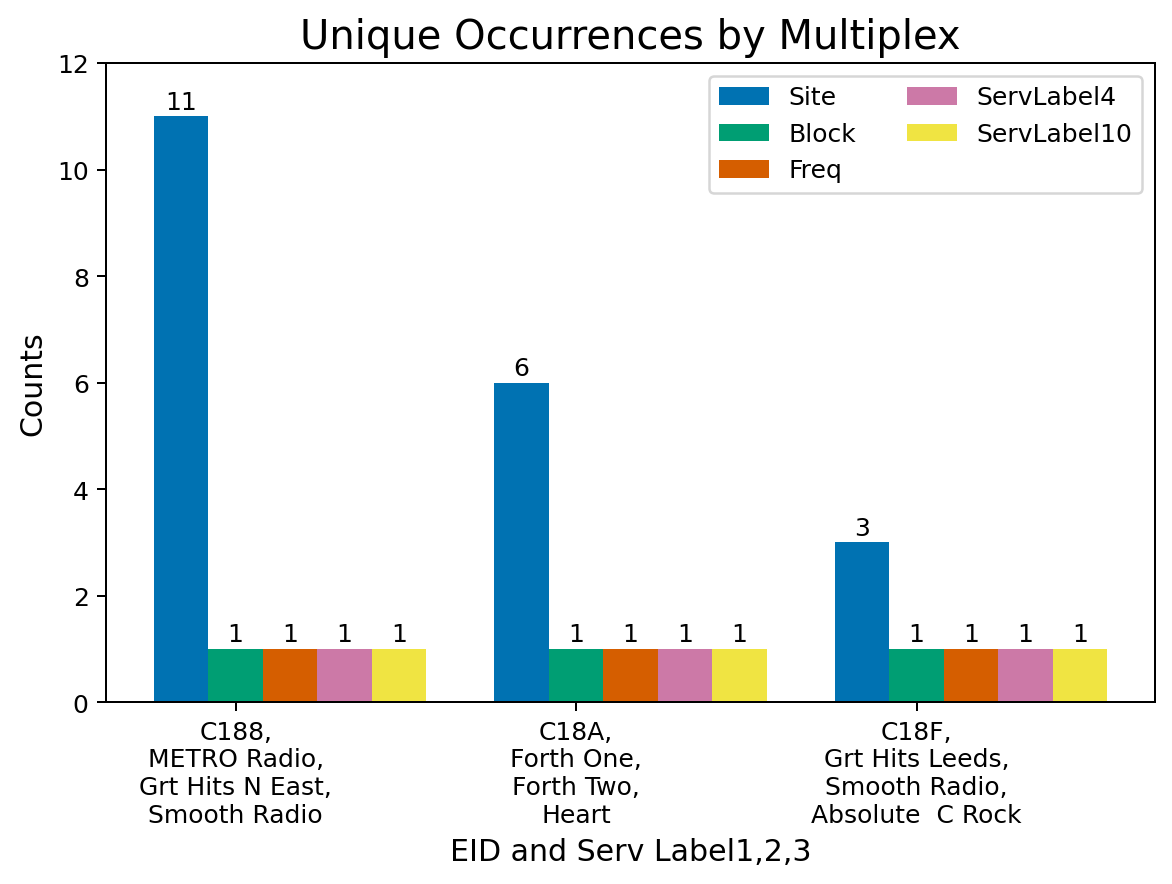

In [22]:
prep.generate_graph('test_data.json')

### Correlation analysis 


## $\rho = 1 - {\frac {6 \sum_{i=1}^{n} d_i^2}{n(n^2 -1)}}$ 
#### $d_i$ = the difference between the ranks of the variable $x_i, y_i$ , $n$ = the number of observations 


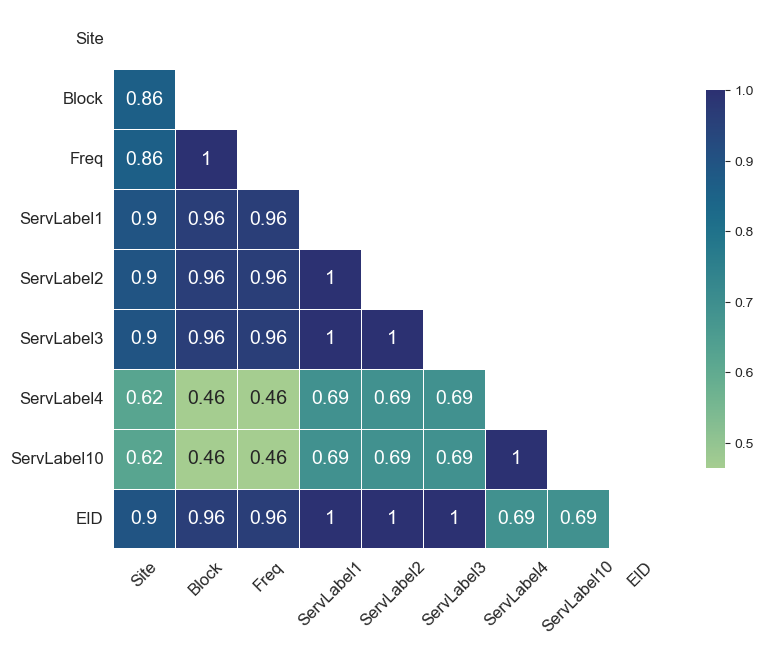

[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


,Site,Block,Freq,ServLabel1,ServLabel2,ServLabel3,ServLabel4,ServLabel10,EID
Site,1.000000,0.862764,0.862764,0.897365,0.897365,0.897365,0.619240,0.619240,0.897365
Block,0.862764,1.000000,1.000000,0.961441,0.961441,0.961441,0.464420,0.464420,0.961441
Freq,0.862764,1.000000,1.000000,0.961441,0.961441,0.961441,0.464420,0.464420,0.961441
ServLabel1,0.897365,0.961441,0.961441,1.000000,1.000000,1.000000,0.690066,0.690066,1.000000
ServLabel2,0.897365,0.961441,0.961441,1.000000,1.000000,1.000000,0.690066,0.690066,1.000000
ServLabel3,0.897365,0.961441,0.961441,1.000000,1.000000,1.000000,0.690066,0.690066,1.000000
ServLabel4,0.619240,0.464420,0.464420,0.690066,0.690066,0.690066,1.000000,1.000000,0.690066
ServLabel10,0.619240,0.464420,0.464420,0.690066,0.690066,0.690066,1.000000,1.000000,0.690066
EID,0.897365,0.961441,0.961441,1.000000,1.000000,1.000000,0.690066,0.690066,1.000000


In [31]:
# read JSON 
dframe = prep.prepare_analysis('test_data.json')[0]
# extract necessary cols from the filtered data
base_df = dframe.iloc[:, 6:15]

# categorical to numerical
samples_df = base_df[:].apply(lambda x: pd.factorize(x)[0])

# Spearman correlations
corr_table = samples_df.corr(method='spearman')

# mask to apply for triangular heatmap
corr_mask = np.zeros_like(corr_table)
triangle_indices = np.triu_indices_from(corr_mask)
corr_mask[triangle_indices] = True
plt.figure(figsize=[9, 7])
# configure heatmap
(sns.heatmap(corr_table, 
             mask=corr_mask, 
             cmap='crest', 
             annot=True, 
             linewidth=.5, 
             annot_kws={'size':14},
             cbar_kws={'shrink':0.7}))

sns.set_style('white')
plt.xticks(rotation=45, size=12)
plt.yticks(size=12)
plt.show()

print(corr_mask)
corr_table # display correlation in a dataframe
# base_df.info()  # checking dataframe


# 4. Performance Evaluation 

In [19]:
def func_timer(fn):
    """
    This function returns the duration of function from the start and end point
    --keyword arguments--
    fn : a function's name to be assessed by this 
    """ 
    def poll(*args, **kwargs):
        start = perf_counter()
        fn(*args, **kwargs)
        return perf_counter() - start
    return poll


# major functions performance using closure
t0 = func_timer(data.read_original_data)
t1 = func_timer(data.list_dataframe)
t2 = func_timer(clean_data.transform_clean_data)
t3 = func_timer(translated_data.save_to_json_file)
t4 = func_timer(translated_data.read_json_file)
t5 = func_timer(prep.json_to_dataframe)


# data must exist for valid testing
t1_time = t1(df)
t2_time = t2()
t3_time = t3(cleaned_df, 'test_data.json')
t4_time = t4('test_data.json')  
t5_time = t5('test_data.json')


print(f'Closure: {t1.__closure__}, {t2.__closure__}, {t3.__closure__}, {t4.__closure__}, {t5.__closure__}')
print('\n=== Function performances measured by time.perf_counter() ===') 
print(f'Read original data takes {t0()} seconds') # Pandas + Python
print(f'Original data into a multiplex list takes {t1_time} seconds') # Python
print(f'Transform clean {t2_time} seconds') # Pandas 
print(f'Save to JSON takes {t3_time} seconds') # Pandas + Python
print(f'Read JSON file takes {t4_time} seconds') # Pandas + Python
print(f'JSON to dataframe takes {t5_time} seconds') # Pandas + Python



Closure: (<cell at 0x7fe774b711e0: method object at 0x7fe773812140>,), (<cell at 0x7fe774b70220: method object at 0x7fe773813cc0>,), (<cell at 0x7fe774b72950: method object at 0x7fe773810880>,), (<cell at 0x7fe774b73eb0: method object at 0x7fe773813600>,), (<cell at 0x7fe774b72590: method object at 0x7fe7738133c0>,)

=== Function performances measured by time.perf_counter() ===
Read original data takes 0.08994767900003353 seconds
Original data into a multiplex list takes 2.2135332759999073 seconds
Transform clean 0.10902151700065588 seconds
Save to JSON takes 0.16043123399958858 seconds
Read JSON file takes 2.286999915668275e-06 seconds
JSON to dataframe takes 0.04029197599993495 seconds


# 5. Graphical User Interface 

### GUI Constants strings

In [21]:
# Collection of menu and prompt strings used in GUI 
GUI_MENU =['Multiplex Information Viewer: beta',  # 0
           'Main Menu', # 1
           'Display Original Data', # 2   
           'Transform & Save Data', # 3 
           'Open Transformed Data',# 4 
           ' Data Information ', # 5 
           'Display Statistics', # 6
           'Display Graph',  # 7
           'Exit',# 8
           '|| Multiplex Data || ',# 9
           'Original Data',# 10
           'Clean and Transform Data', # 11
           'Save data as: ', # 12
           'Search by Multiplex EID', # 13
           'Data Statistics',# 14
           'Graphs', #15
           'Search Results', #16
           'Help',#17
           'About' #18
          ]

GUI_PROMPT = ['Please select from the menu.',  # 0
              'No data to process. Please open data first.', # 1
              'Data cleaned successfully.\n\n',# 2
              'Enter new data name:  \nName can contain maximum \n25 alphanumeric characters, - and _.\n', #3
              'Data saved successfully!' , # 4
              'Requested data doesn\'t exist,\nplease try transform data first.',# 5
              'Data is already processed.', # 6
              'Problem with reading data. \nPlease try again later' ,# 7
              'Image files doesn\'t exist, \ntry to prepare data first.', # 8
              'Are you sure to exit?',# 9
              'Invalid data name. \nOnly Alphanumeric, dash, or underscore are allowed.\n', # 10
              'Something went wrong. \nPlease try again later.', # 11
              'Please open JSON data to proceed. ', #12
              'Enter Multiplex ID (EID) to search: \nEID contains 4 alphanumeric characters only: ', # 13 
              'EID entered does not exist, \nplease try again.', # 14
              'No information found with the EID.' #15 
             ] 


### Application Controls

In [22]:

APP_STATE = START # carries the app's current state
data_name = str()  # string holding data_name defined by user
search_string = str()

# get result and integrat to GUI

def ui_get_original_data():
    # get string version of dataframe read from csv files 
    global APP_STATE
    
    original_data = Data()
    df = original_data.read_original_data()[0]
    data = original_data.list_dataframe(df)
    scroll_text.delete(0.0, tk.END)    
    if len(data) > 0 : # list contains data
        scroll_text.insert(tk.INSERT, data) # update main text
        var.set(GUI_MENU[9] + GUI_MENU[10]) # update header label
        APP_STATE = DATA_OPEN # update the state
        # update info label acc to app state
        info.set(info_string(APP_STATE))
        
        print(f'ui_get_original_data() current state:{APP_STATE}')

    else: # something wrong with reading this should not happen
        tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[5])

        
# app state must be 1 to proceed
def ui_transform_save_data():
    global APP_STATE
    global data_name
    print(f'ui_transform_save_data() current state:{APP_STATE}')
    # Check whether file is opend 
    check_file_is_open()
    
    # check the app state 
    if APP_STATE < DATA_OPEN: # app state too low
        tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[1])    
        
    elif APP_STATE == DATA_OPEN: # valid app state to proceed
        clean_data = CleanData()
        
        # read transformed data by unpacking tuple
        data = clean_data.transform_clean_data()
        
        if data[1] == PROCESSED: # cleining success and ask for data name
           # capture the data name string
            data_name = askstring(GUI_MENU[12], GUI_PROMPT[2]+GUI_PROMPT[3])
            
            if data_name != None: # data name is not empty
                val_result = validate_user_input(data_name, 1)
                if val_result == PROCESSED:# valid data name
                    trans_data = Translation()
                    save_result = trans_data.save_to_json_file(data[0], data_name)
                    if save_result == PROCESSED: # stored success
                        APP_STATE = DATA_TRANSFORMED # update the state
                        # inform file saved ok
                        tk.messagebox.showinfo(title=GUI_MENU[0], message=GUI_PROMPT[4])
                    else: 
                        # storing failed inform the failure
                        tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[11])
                        
                else:# invalid file name - inform user
                    tk.messagebox.showinfo(title=GUI_MENU[0], message=GUI_PROMPT[10])
                    return
            else: # data name is empty -> user exit out
                print(f'ui_transform_save_data() escaping, current state:{APP_STATE}')
                return   
    else:
     # app state it too high -> inform user this is not necessary›
        tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[6])
        return
        

# current state must be 2 to proceed
def ui_open_clean_data(): 
    global APP_STATE
    global data_name
    
    # ask user to input file name 
    data_name = askopenfilename(filetypes=[("JSON file", ".json")])
    if len(data_name) > 0: # name entered ok
        trans = Translation()
        # get JSON file read 
        data = trans.json_multiplex(data_name)  
        if data[1] == PROCESSED: # check data read state is ok
            var.set(GUI_MENU[9] + GUI_MENU[11])
            scroll_text.delete(0.0, tk.END)
            
            scroll_text.insert(tk.INSERT, data[0])
            APP_STATE = DATA_READY
            # get information string to update info label
            info.set(info_string(APP_STATE))
            print(f'ui_open_clean_data: current state:{APP_STATE}{data_name}')
        else: # corrupt or invalid json data 
            tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[7])

    else: # open to no -> exit out
        return
        
         
    
def ui_get_stats():  # current state must be 3 or over to proceed
    
    global APP_STATE
    global data_name

    check_file_is_open()
    if APP_STATE == DATA_READY:  
        print(f'get_stats(): current state:{APP_STATE}{data_name}')
        # check whether the prep is ok (will check json file)
        analysis = Analysis()
        
        if analysis.prepare_analysis(data_name)[1] == PROCESSED:
            info.set(info_string(APP_STATE))
            new_window = Toplevel(root)
            new_window.title(GUI_MENU[0])
            new_window.geometry('400x300')
            Label(new_window, text=GUI_MENU[14], pady=6, font='verdana 14 bold').pack()
            Label(new_window, bg='#fffffc', font='verdana 12', 
                     text=analysis.get_stats(data_name)).pack()
            
        else:  # analysis prep went wrong 
            tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[11])

    else:# no data name exists in cache
        tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[12]) 
        
        

def ui_get_graphs():  
    global APP_STATE
    global data_name
    global graph
    print(f'get graph(): current state:{APP_STATE}')
    check_file_is_open()
    if APP_STATE == DATA_READY:  # json data exist and file is processed for analysis
        analysis = Analysis()
        analysis.generate_graph(data_name)
        # insert plot data into main view        
        info.set(info_string(APP_STATE))
        
        try:
            graph = ImageTk.PhotoImage(Image.open(GRAPH_FILE_1))
            graph_window = Toplevel(root, bg='#FFFFFF')
            graph_window.title(GUI_MENU[0])
            graph_window.geometry('650x500+10+10')
            graph_window.minsize(650, 500)
            graph = tk.PhotoImage(file=GRAPH_FILE_1)
            tk.Label(graph_window, bg='#FFFFFF', padx=5, pady=10, image=graph).pack()


        except FileNotFoundError: # no image file exists - data prep required
            tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[8])

    else : # data name not in cache - opening json file required
        tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[12]) 
     
    

def ui_search():
    global APP_STATE
    global data_name
    global search_string
    items = list()
    check_file_is_open()
    print(f'ui_search(): current state:{APP_STATE}')
    if APP_STATE >= DATA_READY:  # json data exist and opened
        search_string = askstring(GUI_MENU[13], GUI_PROMPT[13] )
        if (search_string != None) : # check user press ok
            if validate_user_input(search_string, 2) == 1:   
                trans = Translation()
                items = trans.search_eid_items(search_string, data_name)
                if len(items) > 0:
                    var.set(GUI_MENU[9] + GUI_MENU[16]) # change header label
                    scroll_text.delete(0.0, tk.END)
                    scroll_text.insert(tk.INSERT, items) # insert result

                    print(f'ui_search(): current state:{APP_STATE}, data name: {data_name}')
                else: # no result
                    tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[15])
            else: # invalid EID
                tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[14])
        else: # user select no --> exit out
            return 
        
    else: # data is not open
        tk.messagebox.showerror(title=GUI_MENU[0], message=GUI_PROMPT[12]) 


def ui_help():
    help_window = Toplevel(root, bg='#FFFFFF')
    help_window.title(GUI_MENU[0])
    help_window.geometry('650x500+10+10')
    help_window.minsize(500, 400)
    tk.Label(help_window, bg='#FFFFFF', padx=5, pady=10, text='').pack()
    
    
def ui_close(): 
    global root
    if tk.messagebox.askokcancel(GUI_MENU[8], GUI_PROMPT[9]) == 'ok':
        APP_STATE == START
        root.quit()
        exit()
        
# to update the app state acc to the file open state
def check_file_is_open():
    global APP_STATE
    current_state = APP_STATE
    if len(scroll_text.get(1.0, 'end-1c')) > 0:
        APP_STATE = current_state
    else:
        # file is not open degrade the app state
        APP_STATE -= 1


### Application View

In [23]:
# Run this cell for GUI|

root = tk.Tk()
root.title(GUI_MENU[0])
root.geometry('950x800+10+10')
root.minsize(950, 800)
menubar = Menu(root)
root.configure(padx=2, pady=2, menu=menubar)

# Menu widget
menu_main = Menu(menubar)
menubar.add_cascade(menu=menu_main, label=GUI_MENU[1])
menu_main.add_command(label=GUI_MENU[2], command=ui_get_original_data)
menu_main.add_command(label=GUI_MENU[4], command=ui_open_clean_data)
menu_main.add_command(label=GUI_MENU[6], command=ui_get_stats)
menu_main.add_command(label=GUI_MENU[7], command=ui_get_graphs)
menu_main.add_command(label=GUI_MENU[17], command=ui_help)
menu_main.add_command(label=GUI_MENU[18], command=ui_help)
menu_main.add_command(label=GUI_MENU[8], command=ui_close)

# all frames in order
main_frame = ttk.Frame(root)
side_frame = ttk.Frame(root)
side_frame.configure(padding=2)
inner_frame = ttk.Frame(main_frame)
inner_frame.configure(padding=2)

side_frame.place(x=0, y=0, relwidth=0.32, relheight=0.7)
main_frame.place(relx=0.32, y=0, relwidth=0.68, relheight=1)

# Side frame
button1 = Button(side_frame, command=ui_get_original_data, text=GUI_MENU[2], font='ariel 13 ', width=8,)
button2 = Button(side_frame, command=ui_transform_save_data, text=GUI_MENU[11], font='ariel 13 ',width=8)
button3 = Button(side_frame, command=ui_open_clean_data, text=GUI_MENU[4], font='ariel 13 ',width=8)
button4 = Button(side_frame, command=ui_search, text=GUI_MENU[13], font='ariel 13 ',width=8)
button5 = Button(side_frame, command=ui_get_stats, text=GUI_MENU[6], font='ariel 13 ',width=8)
button6 = Button(side_frame, command=ui_get_graphs, text=GUI_MENU[7], font='ariel 13 ',width=8)

# side labels 
info = StringVar()
info_label = tk.Label(side_frame, textvariable=info)
menu_label = tk.Label(side_frame, text=GUI_MENU[1], font='ariel 14 bold')
info_head = tk.Label(side_frame, text=GUI_MENU[5], font='ariel 14 bold')


# create grid for main/side frame
side_frame.columnconfigure((0), weight=1, uniform='a')
side_frame.rowconfigure((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), weight=1, uniform='a')

#place widgets on menu
menu_label.grid(row=0, column = 0, sticky='nesw')
button1.grid(row=1, column = 0, sticky='nesw') 
button2.grid(row=2, column = 0, sticky='nesw')
button3.grid(row=3, column = 0, sticky='nesw')
button4.grid(row=4, column = 0, sticky='nesw')
button5.grid(row=5, column = 0, sticky='nesw')
button6.grid(row=6, column = 0, sticky='nesw')

info_head.grid(row=7, column = 0, rowspan=1, sticky='nesw', padx=4)
info_label.grid(row=8, column = 0, rowspan=1, sticky='nesw', padx=4)


# Main frame
var = StringVar() # inform the current viewer 
inner_frame = ttk.Frame(main_frame)
inner_frame.pack(side='left', expand=True, fill='both', padx=5, pady=5)
head_label = ttk.Label(inner_frame,  textvariable=var, font='ariel 16 bold')
var.set(GUI_MENU[9])
head_label.pack(expand=True, fill='both', padx=10, pady=5)

scroll_text = scrolledtext.ScrolledText(inner_frame,
                                       font='verdana 13',
                                       padx=20,
                                       width=140,
                                       height=200,
                                       bg='#fffffc',
                                       fg='#000000',
                                       wrap='none')

scroll_text.pack(padx=(2,1), fill='both')

root.mainloop()


In [28]:
# End of program